# Problem 1: Predicting chaotic Lorenz series using Echo state networks

Echo state networks are a type of recurrent neural networks (RNNs). These are also referred to as reservoir computers sometimes. For further details on Reservoir computing, look at: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.024102

Given a time series of vectors $u(t)$, the RNN predicts the next step of the time series $v(t) = u(t+1)$.

The hidden state of the RNN is updated using the rule:

$$ r(t+1) = \tanh (W_{rr}r(t) + W_{ru} u(t) + b  ),$$

where $W_{rr}, W_{ru}$ and $b$ are fixed parameters (not trained during training).

The output of this RNN is given by

$$ v(t) = W_{vr} r(t), $$

where $W_{vr}$ are trainable parameters. Therefore, this is essentially a linear regression problem.

For prediction of chaotic series, it is important that we fit our training data really well, otherwise, the training error will increase exponentially during prediction. Hence, we would use the exact solution to the linear regression problem.

Note: You are allowed to use sklearn functions for Linear Regression.


After training, we can generate future outputs by feeding in the output $v(t)$ to the network

$$ r(t+1) = \tanh (W_{rr}r(t) + W_{ru} v(t) + b  )$$
$$ v(t+1) = W_{vr} r(t+1), $$

In this problem, we will implement this model to predict the famous Lorenz system, which a three dimensional chaotic series (for more info see, https://en.wikipedia.org/wiki/Lorenz_system).





In [ ]:
# imports
import numpy as np
import pandas as pd
from sklearn import linear_model
from scipy import sparse as sparse
from scipy.sparse import linalg as splinalg
from sys import argv
import matplotlib.pyplot as plt
import pickle
import warnings
from scipy.integrate import odeint, solve_ivp
warnings.filterwarnings("ignore")

Data loading

In [ ]:
# Let us load lorenz series
'''
# in Colab (dtype = np.float128)
fi = open('../datasets/lorenz/lorenz_I1_w1.02_a10.0_R28.0_b2.7_h0.01_dt0.001_skip25.0_T625.dat', 'rb')
series = pickle.load(fi)
'''

series = np.load("../datasets/lorenz/lorenz_series_float64.npy") # dtype = np.float64

# sampling frequency
dt = 0.01

# normalize the series
mean_series = np.mean(series, axis=0)
std_series = np.std(series, axis=0)
series = (series - mean_series)/std_series


The series was sampled at intervals of $\Delta t = 0.01$. Hence, the physical time is obtained by multiplying the length of the series by $\Delta t$.

The Lyapunov exponent of the system is around $0.9$, hence, it would be useful to think about the system in physical time instead of the sampling steps.



Let us plot the time series to see how the signal looks like.

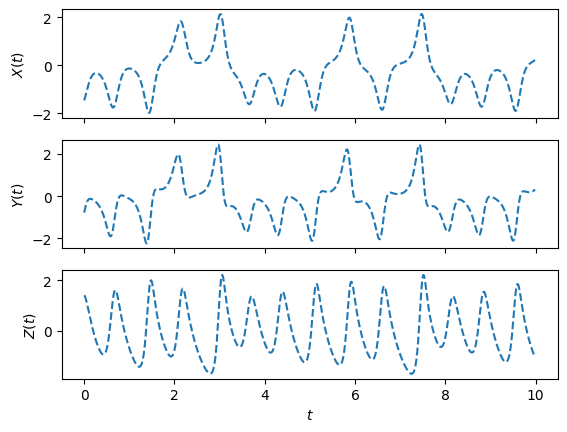

In [28]:
def plot_series(series):

    fig, axes = plt.subplots(3, 1, sharex = True)
    ax = axes[0]
    time = np.arange(len(series))* dt
    ax.plot(time, series[:, 0], '--')
    # ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$X(t)$')

    ax = axes[1]
    ax.plot(time, series[:, 1], '--')
    # ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$Y(t)$')

    ax = axes[2]
    ax.plot(time, series[:, 2], '--')
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$Z(t)$')
    return
#optional: plot the trajectories in 3d to see the Butterfly effect

plot_series(series[:1000])

### Task: Implement an echo state network to predict lorenz series



Initialization:

As we only train the output layer in echo state networks, initializing the state matrix $W_{rr}$ and $W_{ru}$ becomes crucial.

* The state matrix $W_{rr}$ is a sparse matrix with spectral radius $\rho$ and sparsity $s$. The spectral radius is usually less than 1 and sparsity around $1-5\%$. We have provided a function get_Wrr to obtain this matrix given the size of state matrix.
* The input matrix is initialized using uniform distribution $U(-\sigma, \sigma)$

Regularization:

We will use Ridge regression with regularization strength $\alpha$ to avoid overfitting

In [ ]:
# Hyperparameters
rho = 0.9  # spectral radius of state matrix
sparsity = 0.05  # 5% sparsity of state matrix
sigma = 1.0  # sigma for input matrix
alpha = 1e-10


def get_Wrr(sizex, sizey, radius, sparsity):
    "Given the size, spectral radius and sparsity, return a sparse matrix"
    W = sparse.random(sizex, sizey, density=sparsity)
    eigenvalues, eigvectors = splinalg.eigs(W)
    eigenvalues = np.abs(eigenvalues)
    W = (W/np.max(eigenvalues))*radius
    return W

Warming up RNNs:

* For predicting chaotic signals using Echo state networks, the network is first warmed up using the input for a short duration, so that the reservoir state $r(t)$ syncronizes with the input before training / prediction.

* The warm up time is referred as the sync time in reservoir computing literature.

* The output produced during the warmup period is not used for either training or prediction.

* This is an important step because we won't be training the input and reservoir matrices.

The training and testing procedure can be summarized as follows:

* Sync the network for time $T_{sync}$; discard output during this period
* Train the network for time $T_{train}$
* If testing on a new signal, sync the network for time $T_{sync}$; discard the ouput during this period
* Predict the signal for time $T_{test}$



In this problem, we will use $T_{sync} = 5, T_{train} = 500, T_{test} = 20$.

Note that this above quantities are in physical time and to obtain the time series length, we have to divide with $\Delta t = 0.01$.

In [29]:
# train, sync and test times
sync_time = 5
train_time = 500
test_time = 20

### Task: Implement the RNN and plot the predicted trajectories and compare with their true values

Note: It might be handy to use the plot_prediction function below for plotting.

(1500,) (1500, 3) (1500, 3)


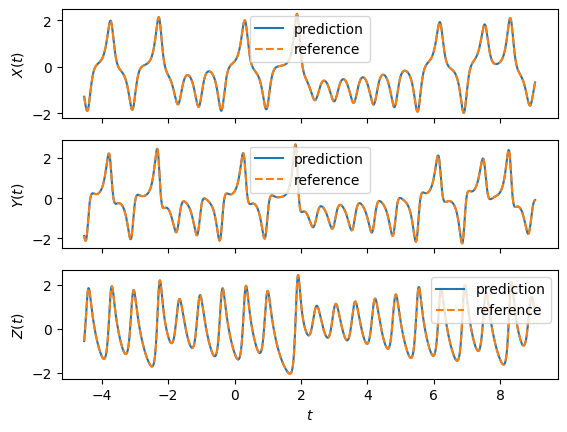

In [49]:
# Using a class here is optional. Feel free to implement in any way you like. The output plots should be similar to one shown below.

class Reservoir:

	def __init__(self, dt = 0.01, lyaps = 0.9056, input_size = 3, reservoir_size = 500, radius = 0.9, sparsity = 0.05, sigma = 1.0, gamma = 1.0, alpha = 1e-10, train_time = 500, sync_time = 5, test_time = 20):
		"""
		Description:
        Reservoir properties:
            input size: dimension of the input
            reservoir size: size of the reservoir (hidden size)
            radius: Spectral radius of W_rr matrix (reservoir matrix)
            sparsity: sparsity of W_rr matrix
            sigma: stdev of the W_ru matrix (input matrix)
            WI: input matrix
            WR: reservoir matrix


        Trraining properties:
            dt = sampling frequency of data
            train_time: train_time/dt
            sync_time: sync_time/dt
            test_time: test_time/dt

        #reservoir states
		    state: reservoir state r(t)
		    output: reservoir output v(t)

		"""

		self.dt = dt
		self.lyaps = lyaps
		self.input_size = input_size
		self.reservoir_size = reservoir_size
		self.radius = radius
		self.sparsity = sparsity
		self.sigma = sigma
		self.gamma = gamma
		self.alpha = alpha
		self.train_time = int(train_time /dt)
		self.sync_time = int(sync_time/dt)
		self.test_time = int(test_time /dt)

		# u(t): given time series
		# estimate v(t) = u(t+1)
		# r(t+1) = tanh( W_rr r(t) + W_ru u(t) + b)
		# v(t+1) = W_vr r(t+1)
		# only W_vr is trained, or found using linear regression

		self.wrr = get_Wrr(self.reservoir_size, self.reservoir_size, self.radius, self.sparsity)
		self.wru = np.random.uniform(-sigma, sigma, size=(self.reservoir_size, self.input_size))

  		# Initialize reservoir state
		self.state = np.zeros(reservoir_size)
		return




	def train(self, series):
		input_data = series[:self.train_time]
		states = []
		targets = input_data[self.sync_time:]  # Training targets

        # Collect reservoir states r(t)
		for t in range(self.train_time):
			u = input_data[t]
			#print(self.wrr.shape, self.wru.shape, u.shape, self.state.shape)
			#print(np.dot(self.wru, u).shape)
			self.state = np.tanh(self.wrr@ self.state + self.wru@ u)
			if t >= self.sync_time:
				states.append(self.state.copy())

        # Convert states to numpy array
		states = np.array(states)

		ridge = linear_model.Ridge(alpha=self.alpha, fit_intercept=False)
		ridge.fit(states, targets)
		self.W_out = ridge.coef_  # Output weights (shape: [num_targets, reservoir_size])

		# Compute training error
		v_pred = ridge.predict(states) # v(t) = W_out r(t)
		mse = np.mean((v_pred - targets) ** 2)
		return mse


	def test(self, series, plot = False):
		# train_time > test_time
		input_data = series[:self.test_time]
		targets = input_data[self.sync_time:]

		states = []
		outputs = []

		for t in range(self.test_time):
			u = input_data[t]
			self.state = np.tanh(self.wrr@ self.state + self.wru@ u )
			states.append(self.state.copy())
			if t >= self.sync_time:
				output = self.W_out @ self.state
				outputs.append(output)

		# Convert outputs to numpy array
		v_pred = np.array(outputs)
		v_truth = targets

		# Compute testing error
		mse = np.mean((v_pred - v_truth) ** 2)

		# Optionally plot predictions
		if plot:
			self.plot_prediction(v_pred, v_truth)

		return mse, self.dt, self.sync_time



	def plot_prediction(self, v_pred, v_truth):

		time = self.dt*(np.arange(v_pred.shape[0]) - self.sync_time)*self.lyaps
		
		print(time.shape, v_pred.shape, v_truth.shape)
		
		fig, axes = plt.subplots(3, 1, sharex = True)
		ax = axes[0]
		ax.plot(time, v_pred[:, 0], '-', label = 'prediction')
		ax.plot(time, v_truth[:, 0], '--', label = 'reference')
		# ax.set_xlabel(r'$t$')
		ax.set_ylabel(r'$X(t)$')
		ax.legend()

		ax = axes[1]
		ax.plot(time, v_pred[:, 1], '-', label = 'prediction')
		ax.plot(time, v_truth[:, 1], '--', label = 'reference')
		# ax.set_xlabel(r'$t$')
		ax.set_ylabel(r'$Y(t)$')
		ax.legend()

		ax = axes[2]
		ax.plot(time, v_pred[:, 2], '-', label = 'prediction')
		ax.plot(time, v_truth[:, 2], '--', label = 'reference')
		ax.set_xlabel(r'$t$')
		ax.set_ylabel(r'$Z(t)$')
		ax.legend()

		plt.show()
		plt.close()
		return


np.random.seed(42)

#create reservoir object
reservoir = Reservoir(dt = dt)
# train reservoir
train_mse = reservoir.train(series)
test_mse, dt_, sync_time = reservoir.test(series, plot = True)



In [23]:
train_mse, test_mse, dt_, sync_time

(np.float64(1.643419010495502e-13),
 np.float64(1.399761179004254e-13),
 0.01,
 500)

# Generating Shakespeare like text using Transformers


In this assignment, we will use language models to generate Shakespeare like text using RNNs and Transformers.

### Data loading and pre-processing

Download the tiny Shakespeare dataset:

In [25]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-08-27 16:34:02--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2025-08-27 16:34:02 (14.8 MB/s) - ‘input.txt’ saved [1115394/1115394]



Load the dataset and print the first $1000$ characters

In [26]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))
# let's look at the first 1000 characters
print(text[:1000])

length of dataset in characters:  1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hung

Vocabulary is the set of unique characters / words in the dataset

In [ ]:
# get the vocabulary
chars = sorted(list(set(text)))  # vocab
vocab_size = len(chars)
print(f'Vocabulary size: {vocab_size}')

# print vocab
print(''.join(chars))

Vocabulary size: 65

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


Let us tokenize the vocabulary by assigning an integer to each character, and write encoder and decoder function to map to and from the character to integer space.

In [ ]:
# create a mapping from characters to integers and vice versa

stoi = {ch:i for i, ch in enumerate(chars)} # abbrev for string to integer
itos = {i:ch for ch, i in stoi.items()}

# encoder: takes a string and returns a list of integers
encode = lambda s: [stoi[c] for c in s]

# decoder: takes a list of integers and returns a string
decode = lambda l: ''.join([itos[i] for i in l])

#unit test
print(encode('hii there'))
print(decode(encode('hii there')))
#Note that 0 is new line
print(stoi)

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


Let us tokenize (map to integers) the entire dataset and create training and test datasets.

In [ ]:
# imports
import torch
import torch.nn as nn
from torch.nn import functional as F

# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = torch.tensor(encode(text), dtype=torch.long).to(device)

# test train split
n = int(0.9*len(data))
train_data = data[:n]  # train dataset
val_data = data[n:]  # test dataset

### Data loader

This data loader samples batch_size sequences, each of length block_size

In [34]:
# data loading
def get_batch(data, batch_size, block_size):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Problem 2: Shakespeare like text generation using Transformers

In this problem, we will generate Shakespeare like text using a decoder only transformer. For simplicity, we will only implement forward pass of a Transformer. The optimization should work without any modifications.



### Part 1: Define a decoder only head to perform scaled dot product attention.

Consider an input $x \in \mathbb{R}^{B \times T \times C}$ to the attention head, where $B$ is the batch size, $T$ is the context length and $C$ is the embedding dimension (input dimension from the last layer).

Then, the attention head of size $d$ outputs $z \in \mathbb{R}^{B \times T \times d}$

$$ z = softmax \left( \frac{Q K^T}{\sqrt{d}} \right) V $$

where $K, Q, V$ are linear (and not affine) transformations of the input

$$ K = k x, \text{ with } k \in \mathbb{R}^{d \times C} $$
$$ Q = q x, \text{ with } q \in \mathbb{R}^{d \times C} $$
$$ V = v x, \text{ with } v \in \mathbb{R}^{d \times C} $$

Define a nn.Module class to implement a decoder only head.


In [ ]:
class Head(nn.Module):
    """Description: decoder only scaled dot product attention"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        """
        Description:
            Initializes various layers used in the forward function
            Note: runs when an object of Head is created
        Input:
            n_embd (C): The embedding dimension
            n_head (d): Hidden dimension of the single head, i.e., key.shape = query.shape = value.shape = (n_embd, head_size)
        """
        # use linear layers to define key, query and value matrices
        # bias is usually not used in nn.Linear in the attention blocks; use bias = False
        self.n_head = n_head
        head_size = n_embd // n_head # head_size d = n_embd / n_head
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # DO NOT MODIFY THE LINE BELOW
        # create a lower triangular matrix for masking out the attention scores before applying softmax
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))


    def forward(self, x):
        """
        Description:
            Forward pass of the attention head
        Input:
            x of shape (B, T, C)
        Output:
            z of shape (B, T, d)
        """
        B, T, C = x.shape # B: batch size; T: block_size; C: embedding dim
        K = self.key(x)   # (B, T, d) d: head size
        Q = self.query(x) # (B, T, d)
        # compute scaled dot product attention scores w = q @ k / sqrt(d)
        W =  Q @ (K.transpose(-2,-1)) / np.sqrt(self.n_head) # (B, T, d) @ (B, d, T) -> (B, T, T)
        # Mask out the attention scores such that each sample has only access to the past
        W = W.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        # apply a softmax along the last dim;
        # use nn.functional.softmax;
        # Note: nn.functional is imported as F
        W = F.softmax(W, dim=-1) # (B, T, T)

        # perform the weighted aggregation of the values: V = v @ x
        V = self.value(x) # (B, T, d)
        # output w @ v
        out = W @ V # (B, T, T) @ (B, T, d) -> (B, T, d)
        return out

### Part 2: Define multi-head attention module

Given input $x \in \mathbb{R}^{B \times T \times C}$ as before, define multiple heads of attention that work in parallel. Use class Head() defined above to create a list of attention heads using nn.ModuleList()

Each attention head returns $z \in \mathbb{R}^{B \times T \times d}$

Using a linear layer, project the concatentated output of attention heads back to the embedding dimension $C$.

In [36]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size): # d: head size
        super().__init__()
        """
        Description: Performs multi-head attention followed by a projection
        Input:
            num_heads: number of attention heads
            head_size (d): size of each attention head
        """
        # n_embd = n_heads * head_size
        self.heads = nn.ModuleList([Head(num_heads * head_size, num_heads) for _ in range(num_heads)]) # Define n_heads copies of Head() of size head_size as a list
        self.proj = nn.Linear(num_heads * head_size, num_heads * head_size) # projection layer using nn.Linear

    def forward(self, x):
        """"
        Description: Forward pass of multi head attention
        Input: x of shape (B, T, C)
        """
        head_outputs = [head(x) for head in self.heads]
        out = torch.cat(head_outputs, dim=-1)
        #project the output using a linear
        out = self.proj(out)
        return out

### Part 3: Implement a simple two layer ReLU FCN $f: \mathbb{R}^n \to \mathbb{R}^n$ with hidden layer dimension $h = 4 \times n$ .

The network should perform the following operations:

1. Linear: $\mathbb{R}^{n \to 4n}$
2. ReLU: $\mathbb{R}^{4n \to 4n}$
3. Linear: $\mathbb{R}^{n \to n}$

In [37]:
class FeedForward(nn.Module):
    """ A simple one hidden layer ReLU block followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(n_embd, 4*n_embd)
        self.linear2 = nn.Linear(4*n_embd, n_embd)
        """
        Description: Linear -> ReLU -> Linear
        """

    def forward(self, x):
        "Forward pass of the network"
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

### Part 4: Implement a Transformer block consisting of multi-head attention followed by feedforward computation

Using the MultiHeadAttention() and Feedforward() classes, define a Transformer block to perform:

1. LayerNorm in the embedding dimension using nn.LayerNorm(n_embd)
2. Multi-head attention with n_head heads of size head_size
3. Add Residual from input
4. LayerNorm in the embedding dimension using nn.LayerNorm(n_embd)
5. Feedforward layer: Linear -> ReLU -> Linear
6. Add Residual from Step 3

In [ ]:
class Block(nn.Module):
    """ Transformer block: Multi head attention followed by feed forward followed by LayerNorm """

    def __init__(self, n_embd, n_head):
        super().__init__()
        """
        Description: Transformer block
        Input:
            n_embd: embedding dimension of the input
            n_head: number of attention heads
        """

        self.mha = MultiHeadAttention(n_head, n_embd // n_head) # head_size = d
        self.ffn = FeedForward(n_embd)

        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

        return

    def forward(self, x):
        "Forward pass of the attention block"

        x_res = x
        x = self.ln1(x)  # Apply LayerNorm
        x = self.mha(x)  # Multi-head attention
        x = x + x_res  # Add residual connection

        # Feedforward network with residual connection
        x = self.ln2(x)  # Apply LayerNorm
        x = self.ffn(x)  # Feedforward network
        x = x + x_res  # Add residual connection

        return x


### Part 5: The full (decoder only) Transformer

Finally, lets put all of it together to construct the full decoder only transformer. Consider the tokenized input $x \in \mathbb{R}^{B \times T \times V}$, where $B$ is the batch size, $T$ is the context length and $V$ is the vocabulary size.

The model should perform the following computations:

1. T = Token embedding(x) $ \in \mathbb{R}^{B \times T \times C}$, where $C$ is the embedding dimension
2. P = Positional embedding(x) $\in \mathbb{R}^{T \times C}$ .For simplicity, we will use the index of the sequence as the positional embedding.
3. X = T + P  $ \in \mathbb{R}^{B \times T \times C}$
4. n_layers of Transformer blocks using the Block() module.
Use nn.Sequential() for stacking mulitple layers
5. LayerNorm in the embeding dimension
6. Linear transformation: $\mathbb{R}^{C} \to \mathbb{R}^{V}$






In [ ]:
class Transformer(nn.Module):
    """
    Description: Decoder only transformer model"""
    def __init__(self, vocab_size, block_size, n_embd, n_layers, n_head):
        super().__init__()
        """
        Description: Decoder only transformer model
        Input:
            vocab_size (V) : Vocabulary dimension
            block_size (T): Context length
            n_embd (C): Embedding dimension
            n_layers: number of layers of Transformer blocks
            n_head : number of heads in multi-head attention
        """
        # replace None with appropriate implementations
        # for simplicity, think of embedding as a linear transformation and fill in the dimensions
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # replace None with the appropriate variables
        self.position_embedding_table = nn.Embedding(block_size, n_embd) # replace None with the appropriate variables
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layers)]) # sequential layer of n_layers Transformer blocks
        self.layer_norm = nn.LayerNorm(n_embd) # Layer norm in the embedding dimension
        self.linear_head = nn.Linear(n_embd, vocab_size) # (C -> V)

    ### DO NOT MODIFY BEYOND THIS
    def forward(self, idx, targets=None):
        """
        Description: Forward pass of transformer
        Inputs:
            idx: The tokenized input sequence
            targets (optional): the tokenized target sequence
        """
        B, T = idx.shape
        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (B, T, C)
        x = tok_emb + pos_emb # (B, T, C): x = E + PE
        x = self.blocks(x) # (B, T, C): multi-head attention block
        x = self.layer_norm(x) # (B, T, C)
        logits = self.linear_head(x) # (B, T, V)

        # computes loss if targets are provided
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    ### DO NOT MODIFY THIS
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx


Estimates training and test loss

In [ ]:
### DO NOT MODIFY THIS
# Estimates loss
@torch.no_grad()
def estimate_loss(data):
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        X, Y = get_batch(data, batch_size, block_size)
        logits, loss =  model(X, Y)
        losses[k] = loss.item()
    mean_loss = losses.mean()
    model.train()
    return mean_loss

Create an instance of the Transformer model and train it using AdamW optimizer

In [ ]:
# hyperparameters
batch_size = 16  # batch_size
block_size = 32  # maximum context length
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3

eval_iters = 200
n_embd = 64
n_head = 4
n_layers = 4
dropout = 0.0

In [44]:
torch.manual_seed(42)

model = Transformer(vocab_size, block_size, n_embd, n_layers, n_head)
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create an optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        train_loss = estimate_loss(train_data)
        val_loss = estimate_loss(val_data)
        print(
            f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

    # sample a batch of data
    xb, yb = get_batch(train_data, batch_size, block_size)

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.4373, val loss 4.4337
step 100: train loss 2.6733, val loss 2.6861
step 200: train loss 2.4578, val loss 2.4570
step 300: train loss 2.3673, val loss 2.3711
step 400: train loss 2.2929, val loss 2.3030
step 500: train loss 2.2519, val loss 2.2649
step 600: train loss 2.2061, val loss 2.2196
step 700: train loss 2.1597, val loss 2.1712
step 800: train loss 2.1216, val loss 2.1529
step 900: train loss 2.0857, val loss 2.1160
step 1000: train loss 2.0792, val loss 2.1138
step 1100: train loss 2.0308, val loss 2.0752
step 1200: train loss 2.0089, val loss 2.0613
step 1300: train loss 1.9912, val loss 2.0454
step 1400: train loss 1.9731, val loss 2.0335
step 1500: train loss 1.9469, val loss 2.0116
step 1600: train loss 1.9348, val loss 2.0014
step 1700: train loss 1.9245, val loss 1.9907
step 1800: train loss 1.8930, val loss 1.9842
step 1900: train loss 1.8848, val loss 1.9708
step 2000: train loss 1.8561, val loss 1.9542
step 2100: train loss 1.